In [1]:
# Install KaggleHub and other dependencies
!pip install kagglehub tensorflow numpy matplotlib nltk h5py



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import kagglehub

path = kagglehub.dataset_download("wenewone/cub2002011")
print("Path to dataset files:", path)


100%|██████████| 1.49G/1.49G [04:07<00:00, 6.47MB/s]

Extracting files...


Path to dataset files: C:\Users\Dilfina\.cache\kagglehub\datasets\wenewone\cub2002011\versions\7


In [5]:
import os

dataset_path = r"C:\Users\Dilfina\.cache\kagglehub\datasets\wenewone\cub2002011\versions\7"
image_dir = os.path.join(dataset_path, "CUB_200_2011/images")
labels_file = os.path.join(dataset_path, "CUB_200_2011/classes.txt")

# Check if paths exist
print("Images directory exists:", os.path.exists(image_dir))
print("Class labels file exists:", os.path.exists(labels_file))

# List all files and directories in the dataset path
for root, dirs, files in os.walk(dataset_path):
    print("Directory:", root)
    for file in files:
        print("File:", file)


Images directory exists: True
Class labels file exists: True
Directory: C:\Users\Dilfina\.cache\kagglehub\datasets\wenewone\cub2002011\versions\7
Directory: C:\Users\Dilfina\.cache\kagglehub\datasets\wenewone\cub2002011\versions\7\CUB_200_2011
File: bounding_boxes.txt
File: classes.txt
File: images.txt
File: image_class_labels.txt
File: README
File: train_test_split.txt
Directory: C:\Users\Dilfina\.cache\kagglehub\datasets\wenewone\cub2002011\versions\7\CUB_200_2011\attributes
File: attributes.txt
File: certainties.txt
File: class_attribute_labels_continuous.txt
File: image_attribute_labels.txt
File: image_attribute_labels_clean.txt
Directory: C:\Users\Dilfina\.cache\kagglehub\datasets\wenewone\cub2002011\versions\7\CUB_200_2011\images
Directory: C:\Users\Dilfina\.cache\kagglehub\datasets\wenewone\cub2002011\versions\7\CUB_200_2011\images\001.Black_footed_Albatross
File: Black_Footed_Albatross_0001_796111.jpg
File: Black_Footed_Albatross_0002_55.jpg
File: Black_Footed_Albatross_0003_79

In [6]:
# Function to load class labels from the file
def load_class_labels(labels_file):
    """Load class labels from the file."""
    class_labels = {}
    with open(labels_file, "r") as f:
        for line in f:
            parts = line.strip().split(" ")
            class_id = parts[0].zfill(3)  # Pad class ID with zeros
            class_name = " ".join(parts[1:])  # Combine the rest as the class name
            class_labels[class_id] = class_name
    return class_labels

# Load and print the class labels
class_labels = load_class_labels(labels_file)
print(f"Loaded {len(class_labels)} class labels.")


Loaded 200 class labels.


In [7]:
def map_images_to_classes(image_dir):
    """Map images to their respective class labels."""
    image_paths = []
    captions = []
    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if os.path.isdir(folder_path):
            class_name = folder_name.split(".")[1]
            for image_file in os.listdir(folder_path):
                image_paths.append(os.path.join(folder_path, image_file))
                captions.append(class_name)
    return image_paths, captions

image_paths, captions = map_images_to_classes(image_dir)
print(f"Mapped {len(image_paths)} images to class labels.")


Mapped 11796 images to class labels.


In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def load_images_and_labels(image_paths, captions, img_size=(64, 64)):
    images = []
    labels = []
    for img_path, caption in zip(image_paths, captions):
        img = load_img(img_path, target_size=img_size)
        img_array = (img_to_array(img) / 127.5) - 1
        images.append(img_array)
        labels.append(caption)
    return np.array(images), labels

images, labels = load_images_and_labels(image_paths, captions)
print(f"Loaded {len(images)} images and their corresponding labels.")


Loaded 11796 images and their corresponding labels.


In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(labels)
tokenized_labels = tokenizer.texts_to_sequences(labels)
max_length = max(len(seq) for seq in tokenized_labels)
padded_labels = pad_sequences(tokenized_labels, maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_length)


Vocabulary size: 233
Max sequence length: 4


In [19]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Reshape, Concatenate, Conv2DTranspose
from tensorflow.keras import Model

def build_generator(vocab_size, max_length):
    text_input = Input(shape=(max_length,))
    text_embedding = Embedding(vocab_size, 256)(text_input)
    text_features = LSTM(256)(text_embedding)

    noise_input = Input(shape=(100,))
    combined = Concatenate()([noise_input, text_features])

    x = Dense(8 * 8 * 256, activation='relu')(combined)
    x = Reshape((8, 8, 256))(x)
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    model = Model([noise_input, text_input], output)
    return model

generator = build_generator(vocab_size, max_length)
generator.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 4, 256)    │     59,648 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 356)       │          0 │ input_layer_7[0]… │
│ (Concatenate)       │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16384)     │  5,849,088 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 256) │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 16, 16,    │    524,416 │ reshape_1[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │    131,136 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 64, 64, 3) │      3,075 │ conv2d_transpose… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,092,675 (27.06 MB)

 Trainable params: 7,092,675 (27.06 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten

def build_discriminator(vocab_size, max_length):
    text_input = Input(shape=(max_length,))
    text_embedding = Embedding(vocab_size, 256)(text_input)
    text_features = LSTM(256)(text_embedding)

    image_input = Input(shape=(64, 64, 3))
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(image_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)

    combined = Concatenate()([x, text_features])
    x = Dense(256, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(x)

    model = Model([image_input, text_input], output)
    return model

discriminator = build_discriminator(vocab_size, max_length)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()


c:\Users\Dilfina\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      3,136 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    131,200 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 4, 256)    │     59,648 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 33024)     │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  8,454,400 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,173,953 (35.00 MB)

 Trainable params: 9,173,953 (35.00 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def build_cgan(generator, discriminator):
    discriminator.trainable = False

    noise_input = Input(shape=(100,))
    text_input = Input(shape=(max_length,))
    generated_image = generator([noise_input, text_input])
    validity = discriminator([generated_image, text_input])

    model = Model([noise_input, text_input], validity)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

cgan = build_cgan(generator, discriminator)
cgan.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 64, 64, 3) │  7,092,675 │ input_layer_10[0… │
│ (Functional)        │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 1)         │  9,173,953 │ functional_3[0][… │
│ (Functional)        │                   │            │ input_layer_11[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,266,628 (62.05 MB)

 Trainable params: 7,092,675 (27.06 MB)

 Non-trainable params: 9,173,953 (35.00 MB)

In [ ]:
def train(generator, discriminator, cgan, images, labels, epochs=1000, batch_size=32):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_images = images[idx]
        real_labels = labels[idx]

        d_loss_real = discriminator.train_on_batch([real_images, real_labels], real)

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, real_labels])
        d_loss_fake = discriminator.train_on_batch([fake_images, real_labels], fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = cgan.train_on_batch([noise, real_labels], real)

        if epoch % 100 == 0:
            print(f"{epoch}/{epochs}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")

train(generator, discriminator, cgan, images, padded_labels, epochs=1000)


c:\Users\Dilfina\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
0/1000, D Loss Real: [array(0.6707704, dtype=float32), array(0.71875, dtype=float32)], D Loss Fake: [array(0.6819758, dtype=float32), array(0.609375, dtype=float32)], G Loss: [array(0.6819758, dtype=float32), array(0.6819758, dtype=float32), array(0.609375, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


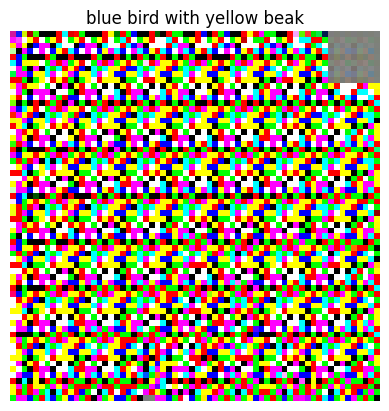

In [15]:
import matplotlib.pyplot as plt

def generate_images(generator, tokenizer, text_description):
    sequence = tokenizer.texts_to_sequences([text_description])
    sequence = pad_sequences(sequence, maxlen=max_length)
    noise = np.random.normal(0, 1, (1, 100))
    generated_image = generator.predict([noise, sequence])
    return (generated_image[0] + 1) / 2.0

text = "blue bird with yellow beak"
generated_image = generate_images(generator, tokenizer, text)

plt.imshow(generated_image)
plt.title(text)
plt.axis("off")
plt.show()
